In [43]:
import tools

In [65]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [66]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


True

In [67]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

import os
from langchain.chat_models import init_chat_model



llm = init_chat_model(
    "azure_openai:gpt-4.1-nano",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version="2024-12-01-preview"
)

agent_tools = [tools.get_all_plants, tools.get_bloom_data_whole]
llm_with_tools = llm.bind_tools(agent_tools)

In [45]:
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

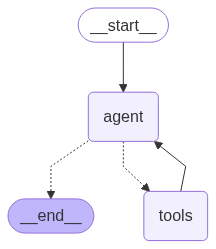

In [64]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
import functools

# def make_specialist(plant) -> callable:
#     sys_msg = SystemMessage(content=f'Du bist ein Assistent, der Informationen über die Blütezeit von der Pflanze {plant} bereitstellt. Nutze get_bloom_data_whole mit {plant} als ersten parameter, um Informationen über die Blütezeit von {plant} zu erhalten.' 
#                             +'Antworte auf die Fragen in folgendme Format: Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }')
#     def assistant(state: MessagesState):
#         return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
    
#     return assistant
def make_specialist(plant):
    blooming = functools.partial(tools.get_bloom_data_whole, plant=plant)

    @rename(f"get_bloom_data_{plant}")

    def get_bloom_data(year: int):
        """
        Get bloom data for the specified plant and year.

        Args:
            year (int): The year for which to retrieve bloom data.

        Returns:
            dict: A dictionary containing bloom data and additional information.
        """
        return blooming(year = year)
    
    specialist_agent = create_react_agent(
        model=llm,
        tools=[get_bloom_data],
        prompt=(
            f'Du bist ein Assistent, der Informationen über die Blütezeit von der Pflanze {plant} bereitstellt. Nutze get_bloom_data_whole mit {plant} als ersten parameter, um Informationen über die Blütezeit von {plant} zu erhalten.'
            'Antworte auf die Fragen in folgendme Format: Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
        ),
        name=f"{plant}_agent",
    )
    return specialist_agent

make_specialist("erle")
        

In [47]:
plant = "erle"
blooming = functools.partial(tools.get_bloom_data_whole, plant=plant)

@rename(f"get_bloom_data_{plant}")

def get_bloom_data(year: int):
    """
    Get bloom data for the specified plant and year.

    Args:
        year (int): The year for which to retrieve bloom data.

    Returns:
        dict: A dictionary containing bloom data and additional information.
    """
    return blooming(year = year)

get_bloom_data(2023)

Tool invoked with plant=erle, year=2023, type=beginn
Tool invoked with plant=erle, year=2023, type=ende


{'begin_data': {'Jahr': {2: 2023},
  'Gebietsmittel': {2: '20.02. '},
  'Abweichung vom Mittel': {2: '-8 Tage'}},
 'ende_data': {'Jahr': {2: 2023},
  'Gebietsmittel': {2: '27.03. '},
  'Abweichung vom Mittel': {2: '0 Tage'}},
 'info_beginn': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Beginn" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.',
 'info_ende': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Ende im Beobachtungsgebiet" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.'}

In [48]:
import os
from langchain_tavily import TavilySearch
os.environ["TAVILY_API_KEY"] = "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"

web_search = TavilySearch(max_results=3)
web_search.invoke("Was ist die Blütezeit von Sonnenblumen?")

{'query': 'Was ist die Blütezeit von Sonnenblumen?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Wann blühen Sonnenblumen? Alles Wichtige zur Blütezeit!',
   'url': 'https://www.pflanzen.schule/pflanzen/blumen/sonnenblume-bluetezeit/',
   'content': 'Die Blütezeit der Sonnenblume ist an den Zeitpunkt gebunden, an dem die Pflanze beginnt, zu keimen. Wenn die Sonnenblumen im Freiland ausgesät werden, ist mit einer Blütezeit im Spätsommer bis Herbst zu rechnen. Wer die Sonnenblumen im Haus vorzieht und bereits Keimlinge oder kleine Pflänzchen ins Beet oder in den Pflanzkübel setzt, kann sich mit einer höheren Wahrscheinlichkeit über',
   'score': 0.9242583,
   'raw_content': None},
  {'title': 'Sonnenblume - Wikipedia',
   'url': 'https://de.wikipedia.org/wiki/Sonnenblume',
   'content': 'Die Gewöhnliche Sonnenblume (Helianthus annuus), auch nur Sonnenblume genannt, ist eine Pflanzenart aus der Gattung der Sonnenblumen (Helianthus) in der Familie 

In [49]:
fallback_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        'Aufgaben:'
        '- Du bist ein Assistent, der Informationen über die Blütezeit von Pflanzen bereitstellt. Suche im Internet nach Informationen.'
        '- Antworte auf die Fragen in folgendme Format: Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
    ),
    name="fallback_agent",
)

In [50]:
plants = tools.get_all_plants()
print(plants)
#create specialists
specialists = {plant: make_specialist(plant) for plant in plants}
[specialist.name for specialist in specialists.values()]

['apfel', 'birke', 'erle', 'hasel', 'winterraps', 'winterroggen', 'esche', 'forsythie', 'huflattich', 'loewenzahn', 'schneegloeckhen', 'beifuss']


['apfel_agent',
 'birke_agent',
 'erle_agent',
 'hasel_agent',
 'winterraps_agent',
 'winterroggen_agent',
 'esche_agent',
 'forsythie_agent',
 'huflattich_agent',
 'loewenzahn_agent',
 'schneegloeckhen_agent',
 'beifuss_agent']

In [60]:
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool


forwarding_tool = create_forward_message_tool("supervisor") # The argument is the name to assign to the resulting forwarded message



supervisor = create_supervisor(
    model =llm,
    agents= list(specialists.values()) + [fallback_agent],
    prompt=(
        'Du bist ein Supervisor, der die Anfragen an Spezialisten weiterleitet. '
        'Wenn du eine Anfrage erhältst, leite sie an den passenden Spezialisten weiter. '
        'Wenn kein passender Spezialist gefunden wird, leite die Anfrage an den Fallback-Agenten weiter.'
        'Nutze das forwarding tool, um die Antworten adn __end__ weiterzuleiten.'
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
    tools=[forwarding_tool]
).compile()

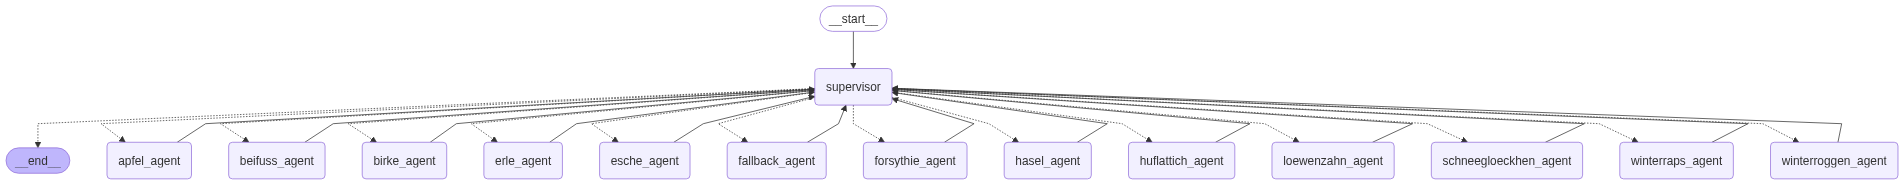

In [61]:


from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))



In [62]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [63]:
messages = [HumanMessage(content="Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?")]
messages = supervisor.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

Tool invoked with plant=erle, year=2020, type=beginn
Tool invoked with plant=erle, year=2020, type=ende
================================ Human Message =================================

Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_erle_agent (call_L1rD0qzGVX2iPFxcCDOJB4ek)
 Call ID: call_L1rD0qzGVX2iPFxcCDOJB4ek
  Args:
================================= Tool Message =================================
Name: transfer_to_erle_agent

Successfully transferred to erle_agent
================================== Ai Message ==================================
Name: erle_agent
Tool Calls:
  get_bloom_data_erle (call_hvwrpsZ3vwUtPAuk7jY9u74f)
 Call ID: call_hvwrpsZ3vwUtPAuk7jY9u74f
  Args:
    year: 2020
================================= Tool Message =================================
Name: get_bloom_data_erle

{"begin_data": 